In [1]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [2]:
import pandas as pd

In [3]:
#df = pd.read_csv("datasets/Aggregation.txt", sep='\t', names=["x", "y", "cluster"])
df = pd.read_csv("datasets/R15.txt", sep='\t', names=["x", "y", "cluster"])
df.head()

,x,y,cluster
0,9.802,10.132,1
1,10.350,9.768,1
2,10.098,9.988,1
3,9.730,9.910,1
4,9.754,10.430,1


In [4]:
np.random.seed(0)

In [5]:
clusters = np.array(df.cluster)
centroids = []
for cluster in np.unique(clusters):
    nodes = np.arange(df.shape[0])[clusters==cluster]
    centroids.append(np.random.choice(nodes, 1)[0])
print(centroids)

[0, 43, 83, 159, 169, 219, 261, 316, 343, 366, 424, 464, 492, 521, 598]


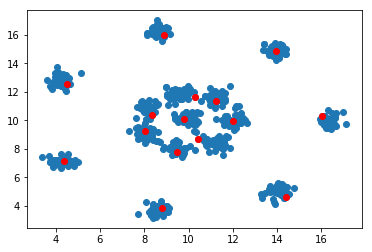

In [6]:
plt.figure()
plt.scatter(df.x, df.y)
plt.scatter(df.x.iloc[centroids], df.y.iloc[centroids], color='r')
plt.show()

In [7]:
positions = np.array(df[["x", "y"]])

In [8]:
def generate_edges(positions, radius=1):
     
    # initialize the edgelist
    N = positions.shape[0]
    idxs = np.arange(N)
    A = [[]]*N
    
    for i in range(N):
        point = positions[i,:]
        dists = np.linalg.norm(point-positions, axis=1)
        neighs = idxs[np.logical_and(dists<=radius, idxs!=i)]
        A[i] = []
        for j, neigh in enumerate(neighs):
            A[i].append((neigh, 1./dists[idxs!=i][j]))
            #A[i].append((neigh, 1))
    return A

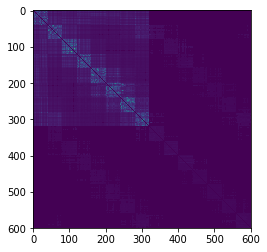

In [9]:
A = generate_edges(positions, 5)
A_mat = list2matrix(A)
plt.figure()
plt.imshow(np.log(A_mat+1))
plt.show()

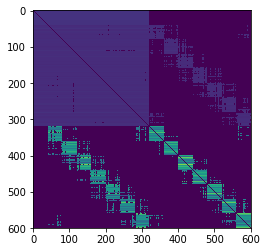

In [19]:
# generate the L matrix
L = localPageRank(A, c=0.85, epsilon=1e-8, max_iters=200, return_only_neighbours=True)

# normalize the edgelist by row
#_, outDeg = getInOutDegree(L)
#for i, nodelist in enumerate(L):
#    for j in range(len(nodelist)):
#        if outDeg[i] > 0:
#            nodelist[j] = (nodelist[j][0], (1+nodelist[j][1])/(outDeg[i]+len(nodelist)-1))

L = transposeEdgelist(L)
L_mat = list2matrix(L)
plt.figure()
plt.imshow(np.log(L_mat+1))
plt.show()

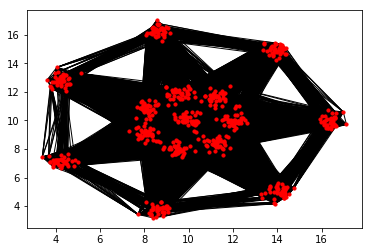

In [20]:
g = nx.Graph(A_mat)
plt.figure()
nx.draw_networkx(g, pos=positions, node_size=10, with_labels=False)
plt.show()

In [21]:
def cluster(L, A_mat=None, pos=None, colors=None, node_size=10, draw_edges=False):
    clusters = -np.ones(len(L), dtype=int)
    parents = np.zeros(len(L), dtype=int)
    # for each node and its neighbours
    for idx in range(len(L)):
        # if it was not already assigned to a cluster:
        if clusters[idx] == -1:
            clusters[idx] = idx
            exit_flag = False
            curr_node = idx
            while not exit_flag:
                next_node = max(L[curr_node], key=lambda x:x[1])[0]
                if clusters[next_node] == -1:
                    clusters[next_node] = idx
                    parents[next_node] = curr_node
                    curr_node = next_node
                else:
                    # if the path didn't close on itself
                    if not clusters[next_node] == idx:
                        # walk backwards and reassign the nodes to the correct cluster
                        while curr_node != idx:
                            clusters[curr_node] = clusters[next_node]
                            curr_node = parents[curr_node]
                        clusters[idx] = clusters[next_node]
                    exit_flag = True
                    
    if A_mat is not None:
        pos, colors = plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)

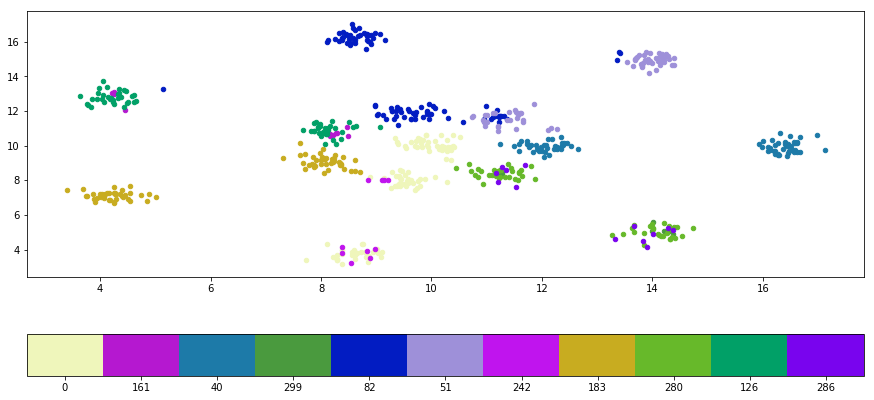

In [22]:
cluster(L, A_mat, pos=positions, node_size=20, draw_edges=False)